In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from paos.util.material import Material
from paos.paos_abcd import ABCD

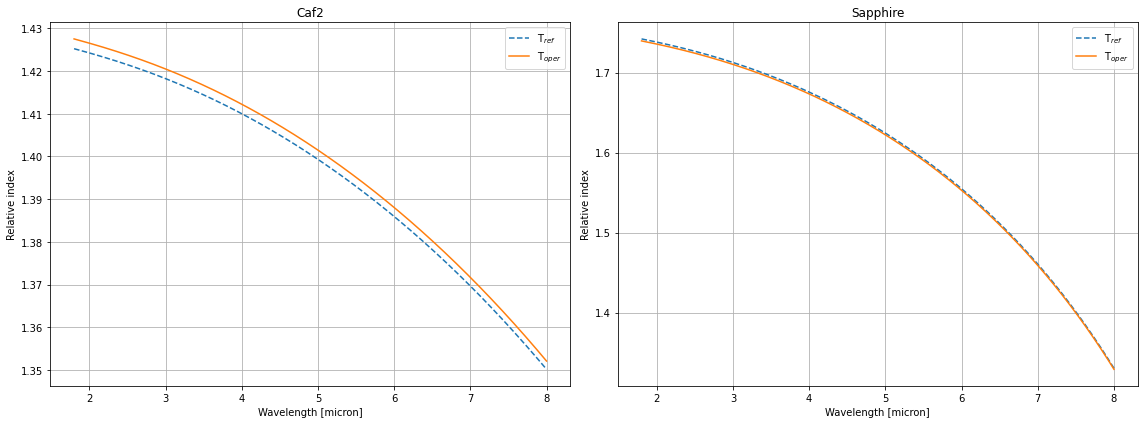

In [3]:
mat = Material(wl = np.linspace(1.8, 8.0, 1024))
mat.plot_relative_index(material_list=['Caf2', 'Sapphire'])

AIRS-CH0

In [4]:
wl0, wl1 = 1.95, 3.9
ncaf0 = mat.nmat0('Caf2', wl0, wl1)[1]
nsap0 = mat.nmat0('Sapphire', wl0, wl1)[1]

In [8]:
# Prism
theta_1 = np.deg2rad(72.1)  # P in: xtilt in
theta_2 = np.deg2rad(-41.9)  # P in: xtilt out
theta_3 = np.deg2rad(-37.6)  # P out: xtilt in
theta_4 = np.deg2rad(60.3)  # P out: xtilt out
thickness = 17.0e-3 # m

A = np.cos(theta_2)*np.cos(theta_4)/(np.cos(theta_1)*np.cos(theta_3))
B = thickness*np.cos(theta_1)*np.cos(theta_4)/(np.cos(theta_2)*np.cos(theta_3))/ncaf0
C = 0.0
D = 1.0/A

abcdt = ABCD()
abcdt.ABCD = np.array([[A,B], [C,D]])
abcds = ABCD()
abcds.ABCD = np.array([[1, thickness/ncaf0], [0, 1]])

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('power', 'M', 'Thickness', 'n1/n2'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}".format(abcdt.power, abcdt.M, abcdt.thickness, abcdt.n1n2))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}".format(abcds.power, abcds.M, abcds.thickness, abcds.n1n2))
print("---------------------")
print("Lens units are meters")

                power|         M| Thickness|     n1/n2
Tangential  -0.000000|     1.514|  0.275203|      1.00
Sagittal    -0.000000|     1.000|  0.011963|      1.00
---------------------
Lens units are meters


In [5]:
# First doublet
abcd = ABCD(thickness = 2.695, curvature =  1.0/31.850,  n1 = 1.0,   n2 = ncaf0)
abcd = ABCD(thickness = 0.5,   curvature = -1.0/150.608, n1 = ncaf0, n2 = 1.0)*abcd
abcd = ABCD(thickness = 1.0,   curvature =  1.0/26.524,  n1 = 1.0,   n2 = nsap0)*abcd
abcd = ABCD(thickness = 0.0,   curvature =  1.0/20.797,  n1 = nsap0, n2 = 1.0)*abcd
(A, B), (C, D) = abcd.ABCD

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('f', 'M', 'Thickness', 'n1/n2', 'Dist. to focus'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -D/C))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -D/C))
print("--------------------------")
print("Lens units are millimeters")

                    f|         M| Thickness|     n1/n2|Dist. to focus
Tangential 100.726761|     0.970|  2.848833|      1.00|    107.07
Sagittal   100.726761|     0.970|  2.848833|      1.00|    107.07
--------------------------
Lens units are millimeters


In [15]:
# Second doublet
abcd = ABCD(thickness = 5.000, curvature =  1.0/91.219,  n1 = 1.0,   n2 = ncaf0)
abcd = ABCD(thickness = 0.955, curvature = -1.0/59.189,  n1 = ncaf0, n2 = 1.0)*abcd
abcd = ABCD(thickness = 1.0,   curvature = -1.0/56.053,  n1 = 1.0,   n2 = nsap0)*abcd
abcd = ABCD(thickness = 0.0,   curvature = -1.0/88.535,  n1 = nsap0, n2 = 1.0)*abcd
(A, B), (C, D) = abcd.ABCD

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('f', 'M', 'Thickness', 'n1/n2', 'Dist. to focus'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -A/C))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -A/C))
print("--------------------------")
print("Lens units are millimeters")

                    f|         M| Thickness|     n1/n2|Dist. to focus
Tangential 142.543536|     1.009|  5.098631|      1.00|    137.44
Sagittal   142.543536|     1.009|  5.098631|      1.00|    137.44
--------------------------
Lens units are millimeters
